In [2]:
from getdist import plots, MCSamples, loadMCSamples
import getdist
import numpy as np 
import matplotlib.pyplot as plt
from matplotlib import rc
rc('font', **{'family': 'sans-serif', 'sans-serif': ['Helvetica']})
rc('text', usetex=True)

In [16]:
class analyse_chains():
    def __init__(self, TATT_fit = False, pert_type = 'physical'):
        self.is_TATT_fit = TATT_fit
        self.pert_type = pert_type
        super().__init__()
        
    def add_S8(self, chains_to_change):
        """ Creates S8 parameter in the chain desired
        """
        for ch in chains_to_change:
            ch.addDerived(np.sqrt(ch['Omega_m']/0.3)*ch['sigma8'], name='S8', label='S8')
        return chains_to_change

    
    def get_means_err_chi2(self, chains_to_extract, eNLA = False):
        """ To get the mean, error and minimum chi squared of your interested parameter in the chain.
        """
        par_dim = len(chains_to_extract)
        
        if self.is_TATT_fit :
            if eNLA == True:
                chmeans = np.zeros((par_dim,5))
                chstd = np.zeros((par_dim,5))
                min_chi2s_idx = np.zeros((par_dim))
                min_chi2s = np.zeros((par_dim))
                best_fit = []
                for ich, ch in enumerate(chains_to_extract):
                    chmeans[ich] = ch.getMeans(pars = [0,1, 2, 3,4])   
                    chstd[ich] = ch.std([0,1,2,3,4])
                    best_fit.append(ch.getParamSampleDict(np.argmin(ch.getParams().chi2), want_derived=True))
                    min_chi2s[ich] = np.min(ch.getParams().chi2)
            if eNLA == False:
                chmeans = np.zeros((par_dim,6))
                chstd = np.zeros((par_dim,6))
                min_chi2s_idx = np.zeros((par_dim))
                min_chi2s = np.zeros((par_dim))
                best_fit = []
                for ich, ch in enumerate(chains_to_extract):
                    chmeans[ich] = ch.getMeans(pars = [0,1, 2, 3,4,5])   
                    chstd[ich] = ch.std([0,1,2,3,4,5])
                    best_fit.append(ch.getParamSampleDict(np.argmin(ch.getParams().chi2), want_derived=True))
                    min_chi2s[ich] = np.min(ch.getParams().chi2)

        return chmeans, chstd, min_chi2s_idx,min_chi2s, best_fit
    
    def unpack_chains(self, param = None):
        path_to_chains = '/mnt/zfsusers/anyabua/IA/mcmc/chains/'
        if self.is_TATT_fit and self.pert_type == 'physical': 
            if param == 'amp':
                amplabel = np.array(['1','075', '050', '025', '0', '025', '050', '075', '1'])
                sign = np.array([-1,-1, -1, -1,0, 1, 1, 1, 1])
                nla_chains = []
                enla_chains = []
                for sa, a, in zip(sign, amplabel):
                    if sa < 0:
                        enla_chains.append(loadMCSamples(path_to_chains + f"eNLA_AMP_NEG0P{a}_PHYSPERT/eNLA_AMP_NEG0P{a}_PHYSPERT", 
                                                        settings={'ignore_rows': 0.3}))
                        nla_chains.append(loadMCSamples(path_to_chains + f"TATTFIT_TO_PHYSPERT/TATTAMP_NEG0P{a}_PHYSPERT/TATTAMP_NEG0P{a}_PHYSPERT", 
                                                        settings={'ignore_rows': 0.3}))
                    if  sa == 0:
                        nla_chains.append(loadMCSamples(path_to_chains + f"TATTFIT_TO_PHYSPERT/TATTAMP_0_PHYSPERT/TATTAMP_0_PHYSPERT", 
                                                        settings={'ignore_rows': 0.3}))
                        enla_chains.append(loadMCSamples(path_to_chains + f"eNLA_AMP_0_PHYSPERT/eNLA_AMP_0_PHYSPERT", 
                                                         settings={'ignore_rows': 0.3}))
                    if sa > 0: 
                        nla_chains.append(loadMCSamples(path_to_chains + f"TATTFIT_TO_PHYSPERT/TATTAMP_POS0P{a}_PHYSPERT/TATTAMP_POS0P{a}_PHYSPERT", 
                                                        settings={'ignore_rows': 0.3}))
                        enla_chains.append(loadMCSamples(path_to_chains + f"eNLA_AMP_POS0P{a}_PHYSPERT/eNLA_AMP_POS0P{a}_PHYSPERT", 
                                                         settings={'ignore_rows': 0.3}))
                return self.add_S8(nla_chains), self.add_S8(enla_chains)
            
            
    def delta_param_over_sigma(self, chain_param, true_val, err, return_error=False):
        if self.pert_type ==  'gaussian' or self.pert_type == 'AIA_2 gaussian':
            delta_param = np.mean(np.fabs(chain_param - true_val))
            mean_err = np.mean(np.fabs(err))
            if return_error:
                delta_param_std = np.sqrt(np.mean(np.fabs(chain_param - true_val)**2))
                return delta_param/mean_err, delta_param_std/mean_err
            return delta_param/mean_err
        else:
            delta_param = np.fabs(chain_param - true_val)
            return delta_param/err

            
    def _plot_chains(self,cosmo_params = True, vary_param = 'amp'):
        sigma8 = 0.81
        omM = 0.30
        S8 = np.sqrt(omM/0.3)*sigma8
        ticksize = 6
        a_1 = 1.0
        a_d = 0.0
        a_2 = 0.0
        etaIa = 0.3
    
                
       
        if self.is_TATT_fit: 
            if cosmo_params:
                nla_pairs = {'\Omega_M': (omM, 0, r'$\frac{\Delta \Omega_{M}}{\sigma_{\Omega_{M}}}$', 'D','blue'),
                         'S_8': (S8, 5, r'$\frac{\Delta S_{8}}{\sigma_{S_{8}}}$', '^', 'magenta')}
                enla_pairs = {'\Omega_M': (omM, 0, r'$\frac{\Delta \Omega_{M}}{\sigma_{\Omega_{M}}}$', 'D','blue'),
                         'S_8': (S8, 4, r'$\frac{\Delta S_{8}}{\sigma_{S_{8}}}$', '^', 'magenta')}
            else:
                nla_pairs = {'A_1': (a_1, 1, r'$\frac{\Delta A_{1}}{\sigma_{A_{1}}}$', 'o','red'),
                         'A_2': (a_2, 2, r'$\frac{\Delta A_{2}}{\sigma_{A_{2}}}$','s', 'yellowgreen'), 
                         'A_d': (a_d, 3, r'$\frac{\Delta A_{d}}{\sigma_{A_{d}}}$', '>', 'darkorange'),
                         '\eta_{IA}': (etaIa, 4, r'$\frac{\Delta \eta_{IA}}{\sigma_{\eta_{IA}}}$', 'X', 'mediumslateblue')}

                
                enla_pairs = {'A_1': (a_1, 1, r'$\frac{\Delta A_{1}}{\sigma_{A_{1}}}$', 'o','red'),
                         'A_d': (a_d, 2, r'$\frac{\Delta A_{d}}{\sigma_{A_{d}}}$', '>', 'darkorange'),
                         '\eta_{IA}': (etaIa, 3, r'$\frac{\Delta \eta_{IA}}{\sigma_{\eta_{IA}}}$', 'X', 'mediumslateblue')}


        if self.pert_type == 'physical':
            if vary_param == 'amp':
                label = r'$k_p=0.3\,{\rm Mpc}^{-1},\,\Delta k=0.11\,{\rm Mpc}^{-1}$'
                x = np.arange(-0.1, 0.125, 0.025)                
                xlab = r'$A_{\rm res}$'
                
            nla_chain, enla_chain = self.unpack_chains(param = vary_param)
            nla_chmeans, nla_chstd, nla_min_chi2s_idx, nla_min_chi2s, nla_best_fit = self.get_means_err_chi2(nla_chain, eNLA = False)
            enla_chmeans, enla_chstd, enla_min_chi2s_idx, enla_min_chi2s, enla_best_fit = self.get_means_err_chi2(enla_chain, eNLA = True)

            figpp = plt.figure(figsize=(10, 8))
            gsp = plt.GridSpec(nrows=2, ncols=1, height_ratios=[2, 1])
            gsp.update(hspace=0.08)
            ax1 = figpp.add_subplot(gsp[0, 0])

            ax1.set_title(label, fontsize = 20)  
            ax2 = figpp.add_subplot(gsp[1, 0])
            plt.setp(ax1.get_xticklabels(), visible=False)
            
            ax2.plot(x, nla_min_chi2s,'x', color = 'green', label = r'${\rm TATT}$')
            ax2.plot(x, enla_min_chi2s,'*', color = 'chocolate', label = r'${\rm eNLA}$')
            ax2.set_ylabel(r'$\chi^{2}_{\rm min}$', fontsize = 28)
            ax2.set_xlabel(xlab, fontsize = 25)
            ax2.tick_params(axis='both', which='major', labelsize = 18, size = ticksize)
            ax1.tick_params(axis='both', which='major', labelsize = 18, size = ticksize)
            
            for key, (true_val, idx, yylabel, marker, color) in nla_pairs.items():
                nla_vals = self.delta_param_over_sigma(nla_chmeans[:,idx], true_val, nla_chstd[:,idx])
                print(true_val)
                print(nla_vals)
                nlalab = r'${\rm TATT}$' + '*' + f'$Q = {key}$'
                ax1.plot(x,nla_vals, marker = marker ,color= color, linestyle = '-', label = nlalab)
                
            markers = []
            colors = []
            for key, (true_val, idx, yylabel, marker, color) in enla_pairs.items():
                enla_vals = self.delta_param_over_sigma(enla_chmeans[:,idx], true_val, enla_chstd[:,idx])
                enlalab = r'${\rm eNLA}$'+'*' + f'$Q = {key}$'
                ax1.plot(x,enla_vals, marker = marker ,color= color, linestyle = '--', label = enlalab)

                ax1.set_ylabel(r'$\frac{\Delta Q}{\sigma_{Q}}$', fontsize = 36)
                
                chi2h, chi2l = ax2.get_legend_handles_labels()
                
            def function_to_split(hand,labl,dividor):

                Hand_L=[]
                Hand_M=[]
                Labl_L=[]
                Labl_M=[]

                for h,l in zip(hand,labl):
                    co=h.get_color()
                    ls=h.get_linestyle()
                    lw=h.get_linewidth()
                    mk=h.get_marker()
                    mew=h.get_markeredgewidth()
                    ms=h.get_markersize()

                    LABS=l.split(dividor)

                    if len(LABS) != 2:
                        print('Split Legends Error: Only exactly 1 Dividor is accepted.')
                        print ('Currently ' + str(len(LABS)-1) + ' dividors were given')
                        return hand,labl

                    #Line and Color
                    LICO = plt.Line2D((0,1),(0,0), color='k', marker='', linestyle=ls,linewidth=lw)
                    #Marker
                    MARK = plt.Line2D((0,1),(0,0), color= co, marker=mk, markeredgewidth=mew, markersize=ms, linestyle='')

                    if LABS[0] not in Labl_L:
                        Hand_L.append(LICO)
                        Labl_L.append(LABS[0])

                    if LABS[1] not in Labl_M:
                        Hand_M.append(MARK)
                        Labl_M.append(LABS[1])

                return Hand_L+Hand_M,Labl_L+Labl_M
            
            hand, labl = ax1.get_legend_handles_labels()
            
            hd, lbl = function_to_split(hand,labl,'*')
            legend1 = ax2.legend(hd,lbl, frameon = False, fontsize = 22 , ncol = 2 , loc = 'lower left', bbox_to_anchor = (0.0, -1.2))
            hd2, lbl2 = ax2.get_legend_handles_labels()
            legend2 = ax2.legend(hd2, lbl2, frameon = False, fontsize = 22 , ncol = 1 , loc = 'lower right', bbox_to_anchor = (1.0, -1))
            ax2.add_artist(legend1)


            plt.show()
            
            if cosmo_params & self.is_TATT_fit:
                figpp.savefig(f'cosmo_NLAdatcompeNLA_{self.pert_type}_{vary_param}_TATTfit.pdf', bbox_inches = 'tight')
            if cosmo_params == False & self.is_TATT_fit:
                figpp.savefig(f'noncosmo_NLAdatcompeNLA_{self.pert_type}_{vary_param}_TATTfit.pdf', bbox_inches = 'tight')


1.0
[0.07710759 0.04545089 0.01229814 0.02557355 0.02979565 0.00083696
 0.02675937 0.00343526 0.01445169]
0.0
[1.25926435 0.96296143 0.55377084 0.20823468 0.06016053 0.32251361
 0.73455618 1.09662595 1.48321991]
0.0
[2.47778642 1.9935362  1.21687655 0.53232202 0.03575329 0.60032169
 1.2684047  1.88452742 2.59701439]
0.3
[0.55996859 0.52693467 0.28488922 0.13286734 0.03926424 0.06213807
 0.20651584 0.26419102 0.34605942]


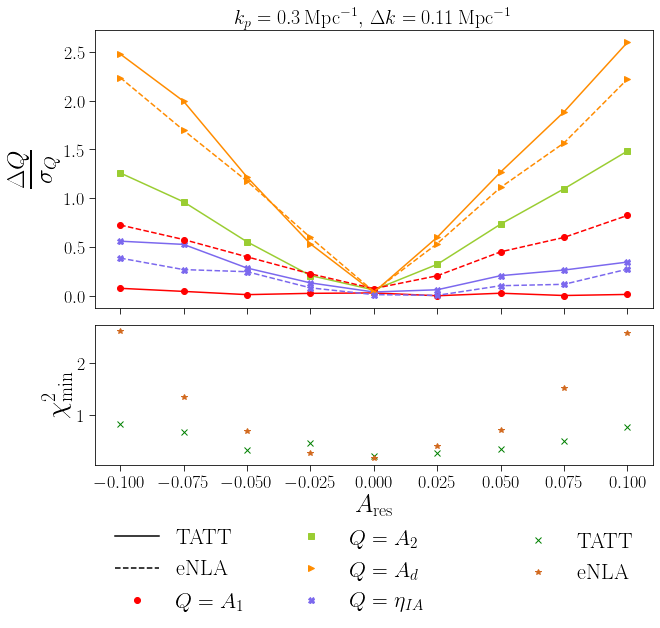

In [17]:
analyse_chains(TATT_fit = True, pert_type = 'physical')._plot_chains(cosmo_params = False)